In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import re

In [3]:
# -------- TASK 1 --------
df = pd.read_csv('IMDB_Dataset.csv')

# Display initial dataset information 
print(f"Initial Dataset Shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}") 
print(f"\nFirst few rows:") 
print(df.head()) 
print(f"\nDataset Info:")
print(df.info()) 
print(f"\nClass Distribution:") 
print(df['sentiment'].value_counts())

# Check for missing values print("\n" + "="*50) 
print("DATA QUALITY ASSESSMENT") 
print("="*50) 
print(f"\nMissing Values:") 
print(df.isnull().sum())
# Check for duplicate records 
print(f"\nDuplicate Records: {df.duplicated().sum()}") 
print(f"Duplicate Reviews (based on text): {df.duplicated(subset=['review']).sum()}")
# Display sample noisy data
print(f"\nSample Review (showing noise):")
print(df['review'].iloc[0][:500])  # First 500 characters


# ============================================
# DATA CLEANING - TECHNIQUE 1 
# ============================================
def clean_text(text):     
 """  Clean text data by removing noise and normalizing         
        Steps:
1.	Convert to lowercase
2.	Remove HTML tags
3.	Remove URLs
4.	Remove special characters and numbers
5.	Remove extra whitespace    """    
 # Convert to lowercase     
 text = text.lower()         
 # Remove HTML tags     
 text = re.sub(r'<.*?>', '', text)         
 # Remove URLs     
 text = re.sub(r'http\S+|www\S+', '', text)     
 # Remove special characters and numbers, keep only letters and spaces     
 text = re.sub(r'[^a-z\s]', ' ', text)         
 # Remove extra whitespace
 text = re.sub(r'\s+', ' ', text).strip()         
 return text
# Apply text cleaning 
print("\n" + "="*50) 
print("APPLYING DATA CLEANING") 
print("="*50) 
print("\nCleaning text data...") 
df['cleaned_review'] = df['review'].apply(clean_text)
# Display before and after cleaning 
print("\nBefore Cleaning:")
print(df['review'].iloc[0][:300]) 
print("\nAfter Cleaning:") 
print(df['cleaned_review'].iloc[0][:300])
# Remove duplicate records 
print(f"\nRemoving duplicate records...") 
initial_size = len(df) 
df = df.drop_duplicates(subset=['cleaned_review'], keep='first') 
final_size = len(df) 
print(f"Records removed: {initial_size - final_size}") 
print(f"Dataset shape after removing duplicates: {df.shape}")
# Reset index after removing duplicates 
df = df.reset_index(drop=True)


# ============================================
# DATA REDUCTION - TECHNIQUE 2: STRATIFIED SAMPLING # ============================================
def stratified_sampling(dataframe, sample_size, class_column):    
    """
    Perform stratified sampling to maintain class distribution
        Parameters:
-	dataframe: Input DataFrame
-	sample_size: Total number of samples to draw
-	class_column: Column name containing class labels
        Returns:
-	Sampled DataFrame with preserved class distribution
    """     
    # Calculate samples per class (proportional sampling)    
    class_counts = dataframe[class_column].value_counts()    
    class_proportions = class_counts / len(dataframe)         
    print(f"Original class distribution:")     
    print(class_counts)     
    print(f"\nClass proportions:")     
    print(class_proportions)         
    # Sample from each class proportionally    
    sampled_dfs = []     
    for class_label, proportion in class_proportions.items():         
        class_sample_size = int(sample_size * proportion)         
        class_df = dataframe[dataframe[class_column] == class_label]         
        class_sample = class_df.sample(n=class_sample_size, random_state=42)        
        sampled_dfs.append(class_sample)         

    # Combine samples from all classes     
    sampled_df = pd.concat(sampled_dfs, ignore_index=True)         

    # Shuffle the combined sample     
    sampled_df = sampled_df.sample(frac=1, random_state=42).reset_index(drop=True)         
    return sampled_df
# Apply stratified sampling print("\n" + "="*50) 
print("APPLYING DATA REDUCTION (STRATIFIED SAMPLING)") 
print("="*50)
# Define sample size (e.g., 20% of original data) 
sample_percentage = 0.2 
sample_size = int(len(df) * sample_percentage)
print(f"\nOriginal dataset size: {len(df)}")
print(f"Sample size ({sample_percentage*100}%): {sample_size}")
# Perform stratified sampling 
df_sampled = stratified_sampling(df, sample_size, 'sentiment')
print(f"\nSampled dataset shape: {df_sampled.shape}")
print(f"\nSampled class distribution:")
print(df_sampled['sentiment'].value_counts())
# Verify proportions are maintained 
print(f"\nOriginal proportions:") 
print(df['sentiment'].value_counts(normalize=True)) 
print(f"\nSampled proportions:")
print(df_sampled['sentiment'].value_counts(normalize=True))


# Save cleaned full dataset 
print("\n" + "="*50) 
print("SAVING PREPROCESSED DATA") 
print("="*50) 
df.to_csv('IMDB_cleaned_full.csv', index=False)
print("\nCleaned full dataset saved as 'IMDB_cleaned_full.csv'")
# Save sampled dataset df_sampled.to_csv('IMDB_cleaned_sampled.csv', index=False) print("Sampled dataset saved as 'IMDB_cleaned_sampled.csv'")
# Summary statistics print("\n" + "="*50) print("PREPROCESSING SUMMARY") 
print("="*50) 
print(f"Original dataset size: 50,000 records") 
print(f"After duplicate removal: {len(df)} records") 
print(f"Sampled dataset size: {len(df_sampled)} records") 
print(f"Data reduction: {(1 - len(df_sampled)/len(df))*100:.2f}%") 
print("\nPreprocessing completed successfully!")

Initial Dataset Shape: (50000, 2)
Columns: ['review', 'sentiment']

First few rows:
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB
None

Class Distribution:
sentiment
positive    25000
negative    25000
Name: count, dtype: int64
DATA QUALITY ASSESSMENT

Missing Values:
review       0
sentiment    0
dtype: int64

Duplicate Records: 418
Duplicate R

In [5]:
#-------- TASK 2 --------
# ============================================
# TASK 3: FEATURE EXTRACTION USING TF-IDF
# ============================================

import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# Load cleaned sampled dataset
print("Loading cleaned sampled dataset...")
df = pd.read_csv("IMDB_cleaned_full.csv")

print(f"Dataset shape: {df.shape}")

# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer(
    max_features=5000,        # Limit vocabulary size
    stop_words='english',     # Remove English stopwords
    ngram_range=(1,2)         # Use unigrams + bigrams (advanced)
)

# Apply TF-IDF on cleaned review column
print("Applying TF-IDF vectorization...")
X_tfidf = tfidf.fit_transform(df['cleaned_review'])

print("TF-IDF transformation complete!")

# Convert to DataFrame (optional)
tfidf_df = pd.DataFrame(
    X_tfidf.toarray(),
    columns=tfidf.get_feature_names_out()
)

print("TF-IDF Matrix Shape:", tfidf_df.shape)

# Display sample features
print("\nSample TF-IDF Features:")
print(tfidf_df.head())

Loading cleaned sampled dataset...
Dataset shape: (49577, 3)
Applying TF-IDF vectorization...
TF-IDF transformation complete!
TF-IDF Matrix Shape: (49577, 5000)

Sample TF-IDF Features:
   aaron  abandoned  abc  abilities  ability  able  absence  absent  absolute  \
0    0.0        0.0  0.0        0.0      0.0   0.0      0.0     0.0       0.0   
1    0.0        0.0  0.0        0.0      0.0   0.0      0.0     0.0       0.0   
2    0.0        0.0  0.0        0.0      0.0   0.0      0.0     0.0       0.0   
3    0.0        0.0  0.0        0.0      0.0   0.0      0.0     0.0       0.0   
4    0.0        0.0  0.0        0.0      0.0   0.0      0.0     0.0       0.0   

   absolutely  ...  young girl  young man  young people  young woman  younger  \
0         0.0  ...         0.0        0.0           0.0     0.000000      0.0   
1         0.0  ...         0.0        0.0           0.0     0.000000      0.0   
2         0.0  ...         0.0        0.0           0.0     0.139064      0.0   
3  

Original dataset: (50000, 2)
After cleaning + dedup: (49577, 3)
Train size (BOTH models): 39661
Test size: 9916

Training models on FULL datasets...
Raw Accuracy (40K full):  0.889
Clean Accuracy (40K full):0.890
Improvement: +0.1%


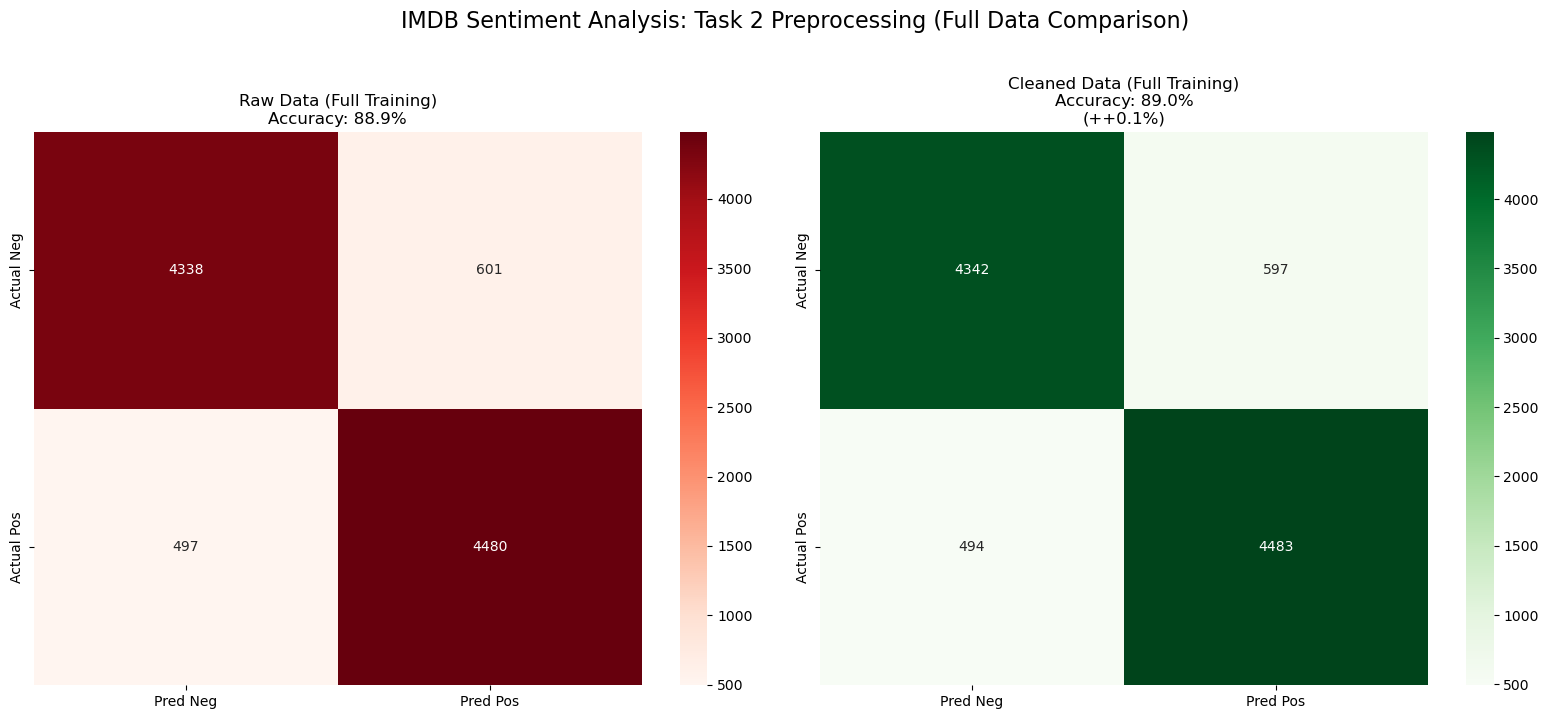


✅ Task 2 COMPLETE: Both models use identical full training data!
Clean beats raw by +0.1%


In [9]:
#-------- TASK 4 --------
df = pd.read_csv('IMDB_Dataset.csv', engine='python', on_bad_lines='warn')
print(f"Original dataset: {df.shape}")

def clean_text(text):
    text = text.lower()
    text = re.sub(r'<.*?>', ' ', text)
    text = re.sub(r'http\S+', ' ', text)
    text = re.sub(r'[^a-zA-Z\s!?.,]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['cleaned'] = df['review'].apply(clean_text)
df_clean = df.drop_duplicates(subset='cleaned').reset_index(drop=True)
print(f"After cleaning + dedup: {df_clean.shape}")

train_idx, test_idx = train_test_split(
    df_clean.index, test_size=0.2, random_state=42,
    stratify=df_clean['sentiment']
)

X_train_raw = df_clean.loc[train_idx, 'review']
X_test_raw = df_clean.loc[test_idx, 'review']
X_train_clean = df_clean.loc[train_idx, 'cleaned']
X_test_clean = df_clean.loc[test_idx, 'cleaned']
y_train = df_clean.loc[train_idx, 'sentiment'].map({'positive': 1, 'negative': 0})
y_test = df_clean.loc[test_idx, 'sentiment'].map({'positive': 1, 'negative': 0})

print(f"Train size (BOTH models): {len(y_train)}")
print(f"Test size: {len(y_test)}")


tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
X_train_raw_vec = tfidf.fit_transform(X_train_raw)
X_test_raw_vec = tfidf.transform(X_test_raw)
X_train_clean_vec = tfidf.transform(X_train_clean)
X_test_clean_vec = tfidf.transform(X_test_clean)

print("\nTraining models on FULL datasets...")
model_raw = LogisticRegression(random_state=42, max_iter=1000)
model_raw.fit(X_train_raw_vec, y_train)
raw_acc = model_raw.score(X_test_raw_vec, y_test)

model_clean = LogisticRegression(random_state=42, max_iter=1000)
model_clean.fit(X_train_clean_vec, y_train)
clean_acc = model_clean.score(X_test_clean_vec, y_test)

print(f"Raw Accuracy (40K full):  {raw_acc:.3f}")
print(f"Clean Accuracy (40K full):{clean_acc:.3f}")
print(f"Improvement: {clean_acc - raw_acc:+.1%}")

y_pred_raw = model_raw.predict(X_test_raw_vec)
y_pred_clean = model_clean.predict(X_test_clean_vec)
cm_raw = confusion_matrix(y_test, y_pred_raw)
cm_clean = confusion_matrix(y_test, y_pred_clean)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

sns.heatmap(cm_raw, annot=True, fmt='d', cmap='Reds',
            xticklabels=['Pred Neg', 'Pred Pos'],
            yticklabels=['Actual Neg', 'Actual Pos'], ax=ax1)
ax1.set_title(f'Raw Data (Full Training)\nAccuracy: {raw_acc:.1%}', fontsize=12)

sns.heatmap(cm_clean, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Pred Neg', 'Pred Pos'],
            yticklabels=['Actual Neg', 'Actual Pos'], ax=ax2)
ax2.set_title(f'Cleaned Data (Full Training)\nAccuracy: {clean_acc:.1%}\n(+{clean_acc-raw_acc:+.1%})', fontsize=12)

plt.suptitle('IMDB Sentiment Analysis: Task 2 Preprocessing (Full Data Comparison)', fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig('task2_full_data_comparison.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("\n✅ Task 2 COMPLETE: Both models use identical full training data!")
print(f"Clean beats raw by {clean_acc - raw_acc:+.1%}")

In [10]:
#-------- TASK 5 --------

#Load pre-cleaned dataset
df = pd.read_csv('IMDB_cleaned_full.csv')
print(df.shape)           #(49577, 3) -> review | sentiment | cleaned_review
print(df.columns.tolist())

#Verify the cleaned_review column exists and is clean
print(df['cleaned_review'].iloc[0][:200])
print("Missing cleaned_review:", df['cleaned_review'].isnull().sum())

#SAMPLING: 5 positive + 5 negative = 10 objects
np.random.seed(42)
df_t5 = (
    df.groupby('sentiment', group_keys=False)
      .apply(lambda x: x.sample(n=5, random_state=42))
      .reset_index(drop=True)
)
df_t5['obj_id'] = [f'R{i+1:02d}' for i in range(10)]

print(df_t5[['obj_id', 'sentiment', 'cleaned_review']])
print("Class distribution:", df_t5['sentiment'].value_counts().to_dict())

(49577, 3)
['review', 'sentiment', 'cleaned_review']
one of the other reviewers has mentioned that after watching just oz episode you ll be hooked they are right as this is exactly what happened with me the first thing that struck me about oz was its br
Missing cleaned_review: 0
  obj_id sentiment                                     cleaned_review
0    R01  negative  this is the most disturbing film i have ever s...
1    R02  negative  this movie was probably one of the worst movie...
2    R03  negative  this is by far the worst non english horror mo...
3    R04  negative  blue desert may have had the potential to be e...
4    R05  negative  the writer director of this film obviously doe...
5    R06  positive  not since the simpsons made it s debut has the...
6    R07  positive  finding the premise intriguing and reading the...
7    R08  positive  real cool smart movie i loved sheedy s colors ...
8    R09  positive  why all the negative reviews you didn t expect...
9    R10  positive  

C:\Users\smera\AppData\Local\Temp\ipykernel_3732\2427972385.py:16: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=5, random_state=42))


In [11]:
#Confirm cleaning
sample_idx = 0

print("── RAW review ──")
print(df_t5['review'].iloc[sample_idx][:300])

print("\n── CLEANED review ──")
print(df_t5['cleaned_review'].iloc[sample_idx][:300])

import re
has_html = df_t5['cleaned_review'].str.contains(r'<[^>]+>', regex=True)
print(f"\nReviews still containing HTML tags: {has_html.sum()}")

has_upper = df_t5['cleaned_review'].str.contains(r'[A-Z]')
print(f"Reviews with uppercase chars: {has_upper.sum()}")

── RAW review ──
This is the most disturbing film I have ever seen. It makes "Requiem for a Dream" look like a Disney film. Although, technically, it is reasonably well made, acting, cinematography, music, directing, etc., are good. However, the concluding gang rape scene is the most appalling and violent thing I ha

── CLEANED review ──
this is the most disturbing film i have ever seen it makes requiem for a dream look like a disney film although technically it is reasonably well made acting cinematography music directing etc are good however the concluding gang rape scene is the most appalling and violent thing i have ever seen an

Reviews still containing HTML tags: 0
Reviews with uppercase chars: 0


In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import itertools

#TF-IDF
vectorizer = TfidfVectorizer(
    max_features  = 5000,         #top 5000 terms by corpus TF-IDF weight
    ngram_range   = (1, 2),        #unigrams + bigrams ("good film", "bad acting")
    sublinear_tf  = True,          #1+log(TF) - handles long-review dominance
    stop_words    = 'english',     #sklearn built-in stops (the, is, a, etc.)
    min_df        = 1,             #must appear in ≥1 doc (fine for n=10)
    max_df        = 0.85,          #ignore terms in >85% of docs (too generic)
    strip_accents = 'unicode',
    analyzer      = 'word'
)

tfidf_matrix = vectorizer.fit_transform(df_t5['cleaned_review'])
print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")
print(f"Vocabulary size: {len(vectorizer.vocabulary_)}")

#Full 10×10 pairwise cosine similarity matrix
sim_matrix = cosine_similarity(tfidf_matrix)
ids = df_t5['obj_id'].tolist()
sim_df = pd.DataFrame(sim_matrix, index=ids, columns=ids)

print("\nPairwise Cosine Similarity Matrix:")
print(sim_df.round(4))

#Extract all C(10,2) = 45 unique pairs
pairs = []
for i, j in itertools.combinations(range(10), 2):
    pairs.append({
        'pair'    : f"{ids[i]}–{ids[j]}",
        'score'   : round(sim_matrix[i][j], 6),
        'sent_A'  : df_t5.iloc[i]['sentiment'],
        'sent_B'  : df_t5.iloc[j]['sentiment'],
        'same_cls': df_t5.iloc[i]['sentiment'] == df_t5.iloc[j]['sentiment']
    })

ranked = pd.DataFrame(pairs).sort_values('score', ascending=False)

print("\n── TOP 10 PAIRS ──")
print(ranked.head(10).to_string(index=False))

#Find max pair
top = ranked.iloc[0]
print(f"\nMAX SIMILARITY: {top['pair']}  →  {top['score']:.6f}")
print(f"  Sentiment A: {top['sent_A']}  |  Sentiment B: {top['sent_B']}")
print(f"  Same sentiment class: {top['same_cls']}")

TF-IDF matrix shape: (10, 1511)
Vocabulary size: 1511

Pairwise Cosine Similarity Matrix:
        R01     R02     R03     R04     R05     R06     R07     R08     R09  \
R01  1.0000  0.0357  0.0341  0.0103  0.0274  0.0167  0.0120  0.0359  0.0257   
R02  0.0357  1.0000  0.0473  0.0261  0.0294  0.0444  0.0288  0.0113  0.0400   
R03  0.0341  0.0473  1.0000  0.0121  0.0201  0.0224  0.0029  0.0052  0.0272   
R04  0.0103  0.0261  0.0121  1.0000  0.0137  0.0328  0.0050  0.0028  0.0188   
R05  0.0274  0.0294  0.0201  0.0137  1.0000  0.0240  0.0193  0.0027  0.0043   
R06  0.0167  0.0444  0.0224  0.0328  0.0240  1.0000  0.0201  0.0075  0.0217   
R07  0.0120  0.0288  0.0029  0.0050  0.0193  0.0201  1.0000  0.0021  0.0213   
R08  0.0359  0.0113  0.0052  0.0028  0.0027  0.0075  0.0021  1.0000  0.0259   
R09  0.0257  0.0400  0.0272  0.0188  0.0043  0.0217  0.0213  0.0259  1.0000   
R10  0.0387  0.0553  0.0340  0.0168  0.0420  0.0337  0.0173  0.0127  0.0388   

        R10  
R01  0.0387  
R02  0.0553 

In [13]:
#Pull max pair and display shared vocabulary
top_row  = ranked.iloc[0]
id_a, id_b = top_row['pair'].split('–')
idx_a = df_t5[df_t5['obj_id'] == id_a].index[0]
idx_b = df_t5[df_t5['obj_id'] == id_b].index[0]

row_a = df_t5.iloc[idx_a]
row_b = df_t5.iloc[idx_b]

print(f"Pair: {id_a} ({row_a.sentiment}) ↔ {id_b} ({row_b.sentiment})")
print(f"Score: {top_row['score']:.6f}\n")

print("── cleaned_review A (first 300 chars) ──")
print(row_a['cleaned_review'][:300])
print("\n── cleaned_review B (first 300 chars) ──")
print(row_b['cleaned_review'][:300])

#Shared TF-IDF terms
feat   = vectorizer.get_feature_names_out()
vec_a  = tfidf_matrix[idx_a].toarray()[0]
vec_b  = tfidf_matrix[idx_b].toarray()[0]
shared = np.minimum(vec_a, vec_b)

#Top 15 shared terms by shared TF-IDF weight
top_idx = shared.argsort()[::-1][:15]
print("\n── Top 15 Shared TF-IDF Terms ──")
print(f"{'Term':<25} {'A':>8} {'B':>8} {'Shared':>8}")
for i in top_idx:
    if shared[i] > 0:
        print(f"{feat[i]:<25} {vec_a[i]:>8.4f} {vec_b[i]:>8.4f} {shared[i]:>8.4f}")

#Euclidean distance (complementary check)
euc = np.linalg.norm(vec_a - vec_b)
print(f"\nEuclidean distance (TF-IDF space): {euc:.4f}")
print(f"Cosine similarity:                 {top_row['score']:.4f}")

Pair: R02 (negative) ↔ R10 (positive)
Score: 0.055297

── cleaned_review A (first 300 chars) ──
this movie was probably one of the worst movies i ve seen in a very long time a friend of mine grabbed it off the shelf at the video rental store and all but forced me to watch it an action we both deeply regret ehh where to start the writing the acting the quality all of it sucked quite possibly so

── cleaned_review B (first 300 chars) ──
this is a good film for die hard chucky fans okay i m sure it s not as good as what the child s play movie were like but this can get really funny and enjoyable chucky s laughs are hilarious spoilers now not one doll but two meaning double the impact jennifer tilly played the part really well and de

── Top 15 Shared TF-IDF Terms ──
Term                             A        B   Shared
movies                      0.0867   0.1134   0.0867
movie                       0.0643   0.0839   0.0643
good                        0.0622   0.1009   0.0622
like          